# Combining misaligned spectra

*gully* and *Aishwarya*  
November 12, 2021

In [a previous tutorial](https://muler.readthedocs.io/en/latest/tutorials/Combining_uncertainties_with_specutils.html) we saw how to combine spectra that are aligned.  Here we show a new way to combine misaligned spectra.

In [1]:
from muler.hpf import HPFSpectrum
#from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

We'll conduct the same steps as we did in [our previous tutorial on masking](https://muler.readthedocs.io/en/latest/tutorials/Masking_and_flattening.html).

In [3]:
import glob

In [4]:
fns = glob.glob('../../data/muler_example_data/HPF/01_A0V_standards/Goldilocks_*.spectra.fits')

In [5]:
n_spectra = len(fns)

In [6]:
multi_spectra = []
for fn in fns:
    raw_spectrum = HPFSpectrum(file = fn, order=6)
    multi_spectra.append(raw_spectrum)

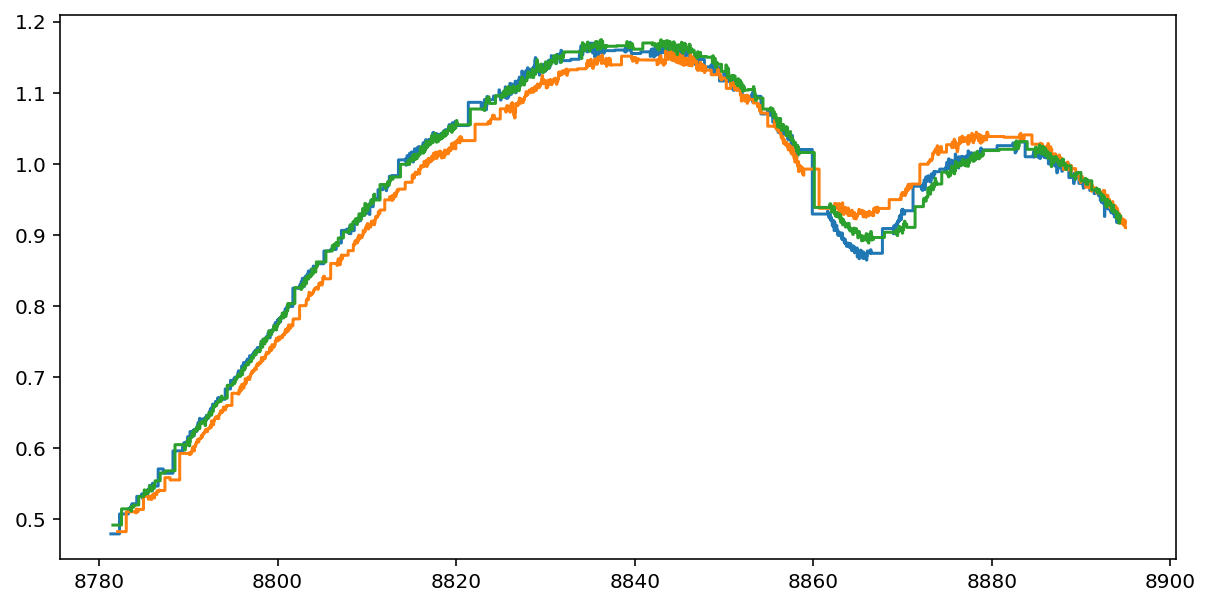

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 5))
clean_multi_spec = []
for i in range(n_spectra):
    clean_spectrum = multi_spectra[i]\
        .trim_edges((4, 2042))\
        .normalize()\
        .mask_tellurics()\
        .barycentric_correct()
    clean_spectrum.plot(ax) #plot singular spectra
    clean_multi_spec.append(clean_spectrum) #save all clean spectra in list

Awesome! We have three spectra we want to combine, *but* the spectra are not aligned! What do we do?

In [8]:
from scipy.stats import binned_statistic

In [9]:
x = [spectrum.wavelength.value for spectrum in clean_multi_spec] #call attribute wavelength for each spectra in list 
y = [spectrum.flux.value for spectrum in clean_multi_spec] #call attribute flux for each spectra in list 
#note: x has units Angstrom, value removes units

In [10]:
x = np.hstack(x) #stacks list horizontally for each spectra
y = np.hstack(y)

In [12]:
# bin_sizes = bins[1:]-bins[0:-1] #right edge minus left edge
# wavelength_out = bins[0:-1]+bin_sizes/2 #half of bin to get center



In [13]:
pixel_midpoints = multi_spectra[0].wavelength.value
bin_sizes=np.diff(pixel_midpoints)
bin_sizes=np.diff(pixel_midpoints,prepend=pixel_midpoints[0]-bin_sizes[0])
bin_sizes.shape

(2048,)

In [14]:
left_edge=pixel_midpoints - bin_sizes/2
right_edge=pixel_midpoints + bin_sizes/2

all_edges=np.hstack((left_edge,right_edge[-1]))

In [15]:
all_edges

array([8781.60849019, 8781.67308395, 8781.73767367, ..., 8895.0432421 ,
       8895.08902103, 8895.134795  ])

In [16]:
all_edges.shape

(2049,)

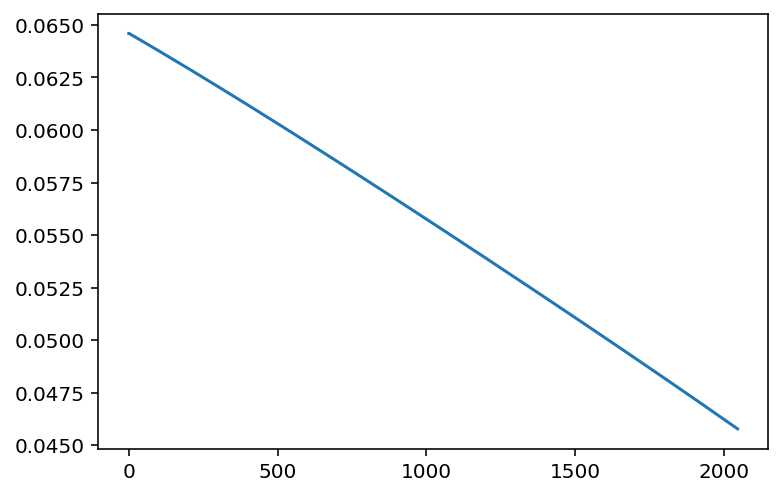

In [17]:
plt.plot(bin_sizes)

In [18]:
# bins = multi_spectra[0].wavelength.value
# wavelength_unit = clean_multi_spec[0].wavelength.unit #Angstrom
# flux_unit = clean_multi_spec[0].flux.unit #dimensionless

In [19]:
result = binned_statistic(x=x,values=y,statistic=np.nanmean,bins=all_edges) #gives combined spectrum

In [20]:
result.bin_edges

array([8781.60849019, 8781.67308395, 8781.73767367, ..., 8895.0432421 ,
       8895.08902103, 8895.134795  ])

In [23]:
result.bin_edges.shape

(2049,)

In [24]:
result.statistic.shape

(2048,)

In [26]:
# bin_sizes = bins[1:]-bins[0:-1] #right edge minus left edge
# wavelength_out = bins[0:-1]+bin_sizes/2 #half of bin to get center

# combined_flux = result.statistic

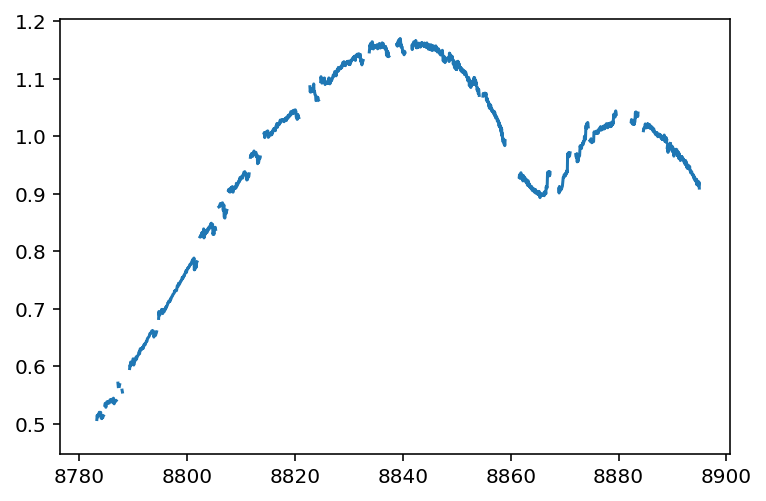

In [27]:
plt.plot(pixel_midpoints,result.statistic) #gaps are telluric corrections
#statistic gives mean object for y value

In [15]:
combined_spectrum = HPFSpectrum(spectral_axis=wavelength_out*wavelength_unit,flux=combined_flux*flux_unit)

<Spectrum1D(flux=<Quantity [nan, nan, nan, ..., nan, nan, nan]>, spectral_axis=<SpectralAxis [8781.67308395, 8781.73767367, 8781.80225525, ..., 8894.99745326,
   8895.0432421 , 8895.08902103] Angstrom>)>

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

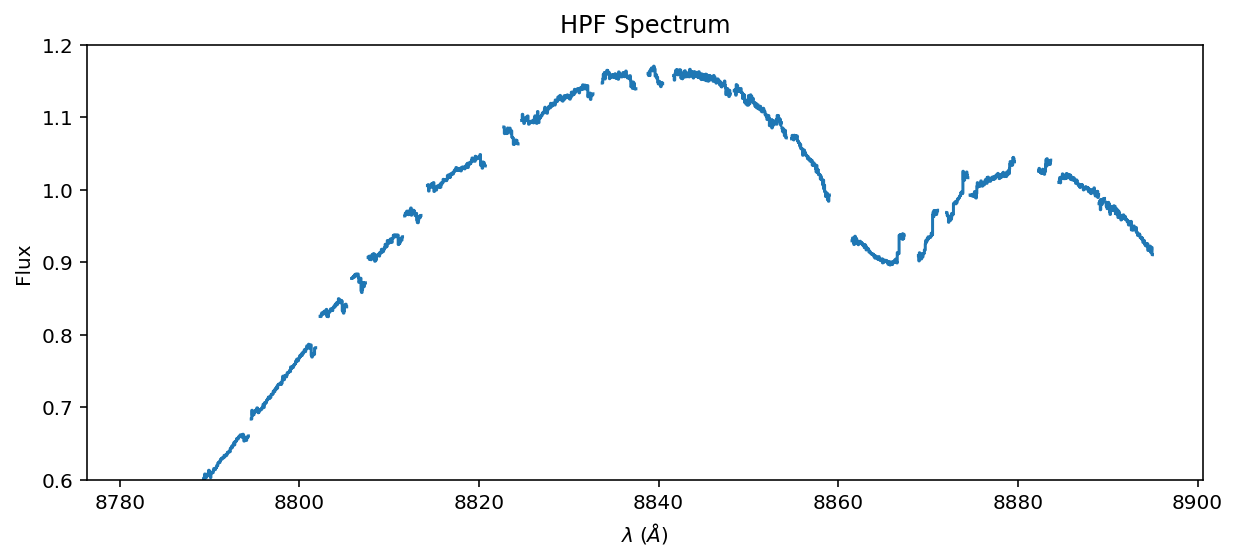

In [16]:
combined_spectrum.plot()